# Loading packages


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import PIL.Image

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
a380vb747 = pd.read_csv("/content/drive/MyDrive/GitHub_Projects/plane_variants/img/a380_v_b747.csv")
a380vb747.head()

,long_model,airline,photo_date,uploaded_date,location,uploader,photo_link,download_path,model,variant,purpose
0,Airbus A320-212,Condor,Photo date: 2020-08-02,Uploaded: 2021-06-16,"Location: Las Palmas/Gran Canaria - GCLP, Spain",By: Carlos GCLP,cdn.jetphotos.com/400/6/34467_1622661605.jpg,./img/A320/cdn.jetphotos.com-400-6-34467_16226...,A320,212,train
1,Airbus A320-214,Uzbekistan Airways,Photo date: 2021-05-10,Uploaded: 2021-06-16,"Location: Minsk - UMMS, Belarus",By: Aleksandr Aleksandrovich,cdn.jetphotos.com/400/6/70881_1622659890.jpg,./img/A320/cdn.jetphotos.com-400-6-70881_16226...,A320,214,test
2,Airbus A320-214,LATAM Airlines,Photo date: 2021-06-02,Uploaded: 2021-06-16,Location: São José do Rio Preto Prof. Eribelto...,By: Paulo H Goncalez,cdn.jetphotos.com/400/6/13959_1622659712.jpg,./img/A320/cdn.jetphotos.com-400-6-13959_16226...,A320,214,train
3,Airbus A320-214,easyJet Europe,Photo date: 2021-05-22,Uploaded: 2021-06-16,"Location: Tenerife Sur-Reina Sofía - GCTS, Spain",By: Pablo Marín,cdn.jetphotos.com/400/5/63632_1622659505.jpg,./img/A320/cdn.jetphotos.com-400-5-63632_16226...,A320,214,validation
4,Airbus A320-232,Cathay Dragon,Photo date: 2021-05-28,Uploaded: 2021-06-16,Location: Hong Kong-Chek Lap Kok Int'l Airport...,By: Jack Sin - HKPSA,cdn.jetphotos.com/400/6/79720_1622659434.jpg,./img/A320/cdn.jetphotos.com-400-6-79720_16226...,A320,232,validation


In [ ]:
train_df = a380vb747.loc[a380vb747.purpose == "train"]
test_df = a380vb747.loc[a380vb747.purpose == "test"]
validation_df = a380vb747.loc[a380vb747.purpose == "validation"]

In [ ]:
train_df.loc[:, "download_path"] = train_df.download_path.str.replace("\\./", "/content/drive/MyDrive/GitHub_Projects/plane_variants/")
test_df.loc[:, "download_path"] = test_df.download_path.str.replace("\\./", "/content/drive/MyDrive/GitHub_Projects/plane_variants/")
validation_df.loc[:, "download_path"] = validation_df.download_path.str.replace("\\./", "/content/drive/MyDrive/GitHub_Projects/plane_variants/")
print(train_df.download_path.head())

0    /content/drive/MyDrive/GitHub_Projects/plane_v...
2    /content/drive/MyDrive/GitHub_Projects/plane_v...
5    /content/drive/MyDrive/GitHub_Projects/plane_v...
6    /content/drive/MyDrive/GitHub_Projects/plane_v...
8    /content/drive/MyDrive/GitHub_Projects/plane_v...
Name: download_path, dtype: object


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


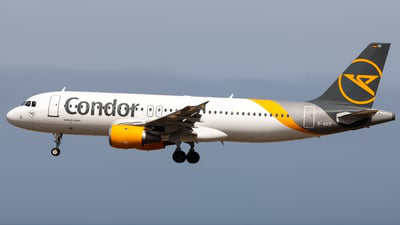

In [ ]:
PIL.Image.open(str(train_df.download_path[0]))

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_dataset = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="download_path",
    y_col="model",
    target_size=(225, 400),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1234)

test_dataset = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col="download_path",
    y_col="model",
    target_size=(225, 400),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1234)

validation_dataset = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=None,
    x_col="download_path",
    y_col="model",
    target_size=(225, 400),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1234)

Found 2657 validated image filenames belonging to 2 classes.
Found 836 validated image filenames belonging to 2 classes.
Found 667 validated image filenames belonging to 2 classes.


# Base model

In [73]:
IMG_SIZE = (225, 400)
BATCH_SIZE = 32

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 8, 13, 1280)
(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [74]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

inputs = tf.keras.Input(shape=(225, 400, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [75]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [82]:
initial_epochs = 3

# loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/3
39/84 [============>.................] - ETA: 6:38 - loss: 0.0000e+00 - accuracy: 0.5144